In [ ]:
####
# @Author: David Hsien
# @Date: 2018/10/10
# @Description: GRU model test
####

%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle as pk
from pprint import pprint
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
import torch.optim as optim
from torch.autograd import Variable
from random import randint
import matplotlib.pyplot as plt

In [ ]:
#Read the data from pickle
with open("All_PM25_data_DataFrame.pk","rb") as file:
    test = pk.load(file)
data_frame = test
data_frame = data_frame.replace(-1,np.nan)
data_frame = data_frame.fillna(method='ffill')

In [ ]:
data_frame.columns

In [ ]:
data_frame.tail()

In [35]:
time_interval = 24
pred_time_interval = 12
start = datetime(2017,1,1)
#Number 14 comes from some missing data in the data frame
end = datetime(2018,1,1) - timedelta(hours = 24 + 14)
date_cursor = start
data_array = np.empty((0,time_interval),int)
label_array = np.empty((0,pred_time_interval),int)
#data_frame['臺南'] = (data_frame['臺南'] - data_frame['臺南'].mean())/(data_frame['臺南'].max() - data_frame['臺南'].min())

#Shift the data for network
while date_cursor != end:
    
    if data_frame['臺南'][(date_cursor + timedelta(hours = time_interval)):(date_cursor + timedelta(hours = time_interval + pred_time_interval - 1))].values.shape[0] == pred_time_interval - 1:
        print("Data ends here", date_cursor)
        break
    
    data_array = np.append(
        data_array,
        data_frame['臺南'][date_cursor:(date_cursor + timedelta(hours = time_interval - 1))].values.reshape(1,time_interval),
        axis=0)

    label_array = np.append(
        label_array,
        data_frame['臺南'][(date_cursor + timedelta(hours = time_interval)):(date_cursor + timedelta(hours = time_interval + pred_time_interval - 1))].values.reshape(1,pred_time_interval),
        axis=0)
    date_cursor += timedelta(hours = 1)

In [ ]:
#Data getter
class data_getter:
    
    def __init__(self, train_or_test, data_num, train_size):
        # Train then 0 and test for 1
        self.train_or_test = train_or_test
        self.data_num = data_num
        self.train_size = int(data_num * train_size)
        if self.train_or_test:
            self.cursor = self.train_size
        else:
            self.cursor = 0
    
    def get(self):
        old_cursor = self.cursor
        self.cursor = self.cursor + 50
        if self.train_or_test:
            if self.cursor > self.data_num:
                self.cursor = int(self.train_size + self.cursor % self.data_num)
                return np.append(data_array[old_cursor:],                               \
                                      data_array[self.train_size : self.cursor],axis=0),\
                    np.append(label_array[old_cursor:],                                 \
                                   label_array[self.train_size : self.cursor],axis=0)
            else:
                return data_array[old_cursor:self.cursor], label_array[old_cursor:self.cursor]
        else:
            if self.cursor > self.train_size:
                self.cursor = int(self.cursor % self.train_size)
                return np.append(data_array[old_cursor:self.train_size],\
                                      data_array[:self.cursor],axis=0), \
                    np.append(label_array[old_cursor:self.train_size],  \
                                      label_array[:self.cursor],axis=0)
            else:
                return data_array[old_cursor: self.cursor], label_array[old_cursor: self.cursor]
##Testing area##
#Test area for data_getter

getter_test = data_getter(1,data_array.shape[0],0.9)
d, l = getter_test.get()
d.shape
#print(d.shape)
#print(l.shape)
#for i in range(1000):
#    d, l = getter_test.get()
#    print(d[0],l[0])
#print("Test complete")

##End of testing area##

In [ ]:
####Try 1:###
#GRU + two fully-connected layer to predict the station with batch size
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

class PM25GRU(nn.Module):
    
    def __init__(self):
        super(PM25GRU, self).__init__()
        self.input_size = 1
        self.hidden_size = 24
        self.layer = 2
        #First three layers GRU
        self.GRU = nn.GRU(self.input_size, self.hidden_size, self.layer, batch_first = True)
        #First fully-connected network
        self.fc1 = nn.Linear(24, 24)
        self.fc2 = nn.Linear(24, 1)
        self.hidden_state = self.init_hidden()
        
    def init_hidden(self):
        return torch.zeros(self.layer, 50, self.hidden_size).to(device)
        
    def forward(self, x, train = True, hidden_state = None):
        #output_tensor = torch.tensor(()).cuda()
        input_tensor = x.view(-1, 24, 1).to(device)
        if train:
            #The connection of network
            GRU_out, hidden_state = self.GRU(input_tensor, hidden_state)
            output = F.relu(self.fc1(GRU_out[:, -1, :]))
            output = F.relu(self.fc2(output))
            return output, hidden_state
        else:
            GRU_out, hidden_state = self.GRU(input_tensor, hidden_state)
            output = F.relu(self.fc1(GRU_out[:, -1, :]))
            output = F.relu(self.fc2(output))
            return output, hidden_state
    
model = PM25GRU()
model.to(device)
print(model)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
running_loss = 0
epoch = 1000
getter = data_getter(0,data_array.shape[0],0.9)
steps = np.arange(1,51)
hidden_state = None


for e in range(epoch):
    #Get the data
    data, label = getter.get()

    #Zero out the grad in model
    model.zero_grad()
    
    #Put them to GPU
    input_data = torch.from_numpy(data).float().to(device)
    label_data = torch.from_numpy(label).float().to(device)

    #Feed the model
    output, hidden_state = model(input_data, True, hidden_state)
    hidden_state = hidden_state.detach()
    hidden_state = torch.autograd.Variable(hidden_state.data, requires_grad=True)
    
    #Train the model
    loss = loss_function(output, label_data)
    loss.backward()

    running_loss += loss.item()
    optimizer.step()
    
    if e and e % 10 == 0:
        fig, ax = plt.subplots()
        ax.plot(steps, label_data.cpu().data.numpy(), 'r-', label='real')
        ax.plot(steps, output.cpu().data.numpy(), 'b-', label='pred')
        ax.set(xlabel="Hours",ylabel="PM25")
        ax.grid()
        plt.show()
        running_loss = 0
        

test_getter = data_getter(1, data_array.shape[0], 0.9)
test_data, test_label = test_getter.get()
test_data = torch.from_numpy(test_data).float().cuda()
test_label = torch.from_numpy(test_label).float().cuda()
steps = np.arange(1,37)

hidden_state = None;

for batch_num in range(30):
    
    test_input = test_data[batch_num]
    test_output = torch.tensor(()).cuda()
    
    
    for time_step in range(12):
        
        output, hidden_state = model(test_input, False, hidden_state)
        test_input = torch.cat((test_input[1:], output.view(-1)))
        test_output = torch.cat((test_output, output.view(-1)))
        
    fig, ax = plt.subplots()
    test = test_label[batch_num : batch_num + 12].view(-1).cpu().data.numpy()
    model_output = test_output.cpu().data.numpy()
    test = np.concatenate((test_data[batch_num].cpu().data.numpy(), test))
    model_output = np.concatenate((test_data[batch_num].cpu().data.numpy(), model_output))
    ax.plot(steps, test, 'r-', label='real')
    ax.plot(steps, model_output, 'b-', label='pred')
    ax.set(xlabel="Hours",ylabel="PM2.5")
    ax.grid()
    plt.show()

In [ ]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
running_loss = 0
epoch = 1000
getter = data_getter(0,data_array.shape[0],0.9)
test_getter = data_getter(1,data_array.shape[0],0.9)
steps = np.arange(1,13)
hidden_state = None


for index in range(epoch):
    #Get the data
    data, label = getter.get()
    test_data, test_label = test_getter.get()
    

    for i in range(data.shape[0]):
        #Zero out the grad in model
        #model.zero_grad()
        #Initialize the weight
        #model.hidden = model.init_hidden()
        #Put input data and label data into GPU
        input_data = torch.from_numpy(np.flip(data[i], axis = 0).reshape((1, model.hidden_size, 1)).copy()).float().to(device)
        label_data = torch.from_numpy(label[i]).float().to(device)
        #Feed the network
        output, hidden_state = model(input_data, hidden_state)
        hidden_state = hidden_state.detach()
        hidden_state = torch.autograd.Variable(hidden_state.data, requires_grad=True)
        #Train the network
        loss = loss_function(output.view(12), label_data)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if index != 0 and index % 10 == 0:
        #Print out the training data and visualize it
        input_data = torch.from_numpy(data[0].reshape((1, model.hidden_size, 1))).float().to(device)
        output, hidden_state = model(input_data, hidden_state)
        hidden_state = hidden_state.detach()
        hidden_state = torch.autograd.Variable(hidden_state.data, requires_grad=True)
        fig, ax = plt.subplots()
        #ax.plot(steps, label[0], 'r-', label='real')
        #ax.plot(steps, output.cpu().data.numpy().reshape((12)), 'b-', label='pred')
        #ax.set(xlabel="Hours",ylabel="value")
        #ax.grid()
        #plt.show()
        testing_data = torch.from_numpy(test_data[0].reshape((1, model.hidden_size, 1))).float().to(device)
        output, hidden_state = model(testing_data, hidden_state)
        hidden_state = hidden_state.detach()
        hidden_state = torch.autograd.Variable(hidden_state.data, requires_grad=True)
        ax.plot(steps, test_label[0], 'r-', label='real')
        ax.plot(steps, output.cpu().data.numpy().reshape((12)), 'b-', label='pred')
        ax.set(xlabel="Hours",ylabel="value")
        ax.grid()
        plt.show()
        print("Running loss:", running_loss / 50, "\r")
        running_loss = 0

In [ ]:
####Try 2:###
#GRU + two fully-connected layer to predict the station 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

class PM25GRU(nn.Module):
    
    def __init__(self):
        super(PM25GRU, self).__init__()
        self.hidden_size = 24
        self.pred_size = 12
        #First four-layered GRU
        self.GRU = nn.GRU(self.hidden_size, self.hidden_size, 3)
        #First fully-connected network
        self.fc1 = nn.Linear(self.hidden_size,12)
        self.fc2 = nn.Linear(12, 1)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return torch.zeros(3, 1, self.hidden_size).to(device)
        
    def forward(self, x, hidden_state):
        input_tensor = x.view(1,1,-1).to(device)
        #The connection of network
        GRU_out, hidden_state = self.GRU(input_tensor, hidden_state)
        output = F.relu(self.fc1(GRU_out))
        output = F.relu(self.fc2(output))
        return output, hidden_state
    
model_2 = PM25GRU()
model_2.to(device)
print(model_2)

In [ ]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(model_2.parameters())
running_loss = 0
epoch = 1000
getter = data_getter(0,data_array.shape[0],0.9)
steps = np.arange(1,13)
hidden_state = None


for e in range(epoch):
    #Get the data
    data, label = getter.get()
    #Get the testing data
    #test_data, test_label = test_getter.get()
    for index in range(data.shape[0]):
        #Zero out the grad in model
        #Initialize the weight
        #hidden_state = model_2.init_hidden()
        #Put them to GPU
        #hidden_state = None
        
        input_data = torch.from_numpy(data[index]).float().to(device)
        label_data = torch.from_numpy(label[index]).float().to(device)
        output_tensor = torch.tensor(()).cuda()
        output_seq = np.empty((0))
        
        for i in range(model_2.pred_size):
            #Feed the model
            output, hidden_state = model_2(input_data, hidden_state)
            output_tensor = torch.cat((output_tensor,output))
            output_seq = np.append(output_seq, output.cpu().data.numpy())
            hidden_state = hidden_state.detach()
            hidden_state = torch.autograd.Variable(hidden_state.data, requires_grad=True)
            #Train the model
            loss = loss_function(output.view(-1), label_data[i])
            loss.backward(retain_graph=True)
            optimizer.step()
            input_data = torch.cat((input_data[-(model_2.hidden_size - 1):], output.view(-1)));
        print(output_seq)
            
        if e % 10 == 0 and index == 0:
            fig, ax = plt.subplots()
            ax.plot(steps, label[index], 'r-', label='real')
            ax.plot(steps, output_seq, 'b-', label='pred')
            ax.set(xlabel="Hours",ylabel="PM25")
            ax.grid()
            plt.show()
            


In [ ]:

####Try 3:####
#Use the same network structure as Seq2Seq except change LSTM to GRU
#Input 96 numbers and output 12 numbers
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

class PM25GRU_decoder(nn.Module):
    
    def __init__(self):
        super(PM25GRU_decoder, self).__init__()
        self.input_GRU = nn.GRU(1, 1, 4, batch_first = True)
        self.output_GRU = nn.GRU(1, 1, 4, batch_first = True)
        self.input_hidden = self.init_hidden()
        self.output_hidden = self.init_hidden()
        
    def init_hidden(self):
        return torch.zeros(4, 1, 1).to(device)
        
    def forward(self, x):
        outputs = []
        GRU_out, self.input_hidden = self.input_GRU(x, self.input_hidden)
        for time_step in range(12):
            GRU_out, self.output_hidden = self.output_GRU(GRU_out[ : , -1, : ].view(1,1,1), self.output_hidden)
            outputs.append(GRU_out)
        return torch.stack(outputs).to(device)
    
model_3 = PM25GRU_decoder()
model_3.to(device)
print(model_3)

In [ ]:

loss_function = nn.MSELoss()
optimizer = optim.Adam(model_3.parameters())
running_loss = 0
epoch = 1000
getter = data_getter(0,data_array.shape[0],0.9)
steps = np.arange(1,13)


for index in range(epoch):
    #Get the data
    data, label = getter.get()
    #Get the testing data
    test_data, test_label = test_getter.get()
    for i in range(data.shape[0]):
        #Zero out the grad in model
        model_3.zero_grad()
        #Initialize the hidden state
        model_3.input_hidden = model_3.init_hidden()
        model_3.output_hidden = model_3.init_hidden()
        #Put them to GPU
        input_data = torch.from_numpy(data[i].reshape(1, 24, 1)).float().to(device)
        label_data = torch.from_numpy(label[i]).float().to(device)
        #Feed the model
        output = model_3(input_data)
        #plt.plot(steps, label[i], 'r-', label='real')
        #plt.plot(steps, output.cpu().data.numpy().reshape((12)), 'b-', label='pred')
        #plt.show()
        #Train the model
        loss = loss_function(output.view(12), label_data)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    #Print out a training data and visualize it
    input_data = torch.from_numpy(data[0].reshape(1, 96, 1)).float().to(device)
    output = model_3(input_data)
    plt.plot(steps, label[0], 'r-', label='real')
    plt.plot(steps, output.cpu().data.numpy().reshape((12)), 'b-', label='pred')
    plt.show()
    print("Running loss:", running_loss / 50, "\r")
    running_loss = 0

In [ ]:
####Try 4:###
#GRU + two fully-connected layer to predict the station 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

class PM25GRU_4(nn.Module):
    
    def __init__(self):
        super(PM25GRU_4, self).__init__()
        self.input_size = 1
        self.hidden_size = 24
        self.pred_size = 12
        self.layer = 5
        #First four-layered GRU
        self.RNN = nn.LSTM(self.input_size, self.hidden_size, self.layer, batch_first = True, bidirectional = True)
        #First fully-connected network
        self.fc1 = nn.Linear(48, 24)
        self.dp1 = nn.Dropout(p = 0.2)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, 24)
        self.fc4 = nn.Linear(24, 24)
        self.fc5 = nn.Linear(24, 1)
        #self.hidden_state = self.init_hidden()
        
    def init_hidden(self):
        return torch.zeros(self.layer * 2, 1, self.hidden_size).to(device)
        
    def forward(self, x, hidden_state):
        input_tensor = x.view(1, -1, 1).to(device)
        #print(input_tensor)
        #The connection of network
        #GRU_out, self.hidden_state = self.GRU(input_tensor, self.hidden_state)
        GRU_out, hidden_state = self.RNN(input_tensor, hidden_state)
        output = F.relu(self.fc1(GRU_out[:, -1, :].view(-1)))
        #output = F.relu(self.fc1(input_tensor.view(-1)))
        output = self.dp1(output)
        output = F.relu(self.fc2(output))
        #output = F.relu(self.fc3(output))
        #output = F.relu(self.fc4(output))
        output = F.relu(self.fc5(output))
        return output, hidden_state
    
model_4 = PM25GRU_4()
model_4.to(device)
print(model_4)

In [ ]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(model_4.parameters())
running_loss = 0
epoch = 1000
getter = data_getter(0,data_array.shape[0], 0.9)
test_getter = data_getter(1, data_array.shape[0], 0.9)
steps = np.arange(1,51)
hidden_state = None


for e in range(epoch):
    #Get the data
    data, label = getter.get()

    output_tensor = torch.tensor(()).float().to(device)
    
    for index in range(data.shape[0]):
        
        #Zero out the gradient of model
        model_4.zero_grad()
        
        #Initialize hidden_state and cell_state
        h_s = torch.zeros(model_4.layer * 2, 1, 24).to(device)
        c_s = torch.zeros(model_4.layer * 2, 1, 24).to(device)
        
        #Prepare Input data
        input_data = torch.from_numpy(data[index]).float().to(device)
        label_data = torch.from_numpy(label[index]).float().to(device)
        
        
        #Feed the model
        output, (h_s, c_s) = model_4(input_data, (h_s, c_s))
        output_tensor = torch.cat((output_tensor,output))
        
        #BP
        loss = loss_function(output.view(-1), label_data)
        loss.backward()
        optimizer.step()

        
    if e % 10 == 0:
        fig, ax = plt.subplots()
        ax.plot(steps, label, 'r-', label='real')
        ax.plot(steps, output_tensor.cpu().data.numpy(), 'b-', label='pred')
        ax.set(xlabel="Hours",ylabel="PM25")
        ax.grid()
        plt.show()

In [ ]:
test_getter = data_getter(1, data_array.shape[0], 0.9)
for i in range(10):
    test_data, test_label = test_getter.get()
    test_data = torch.from_numpy(test_data).float().cuda()
    test_label = torch.from_numpy(test_label).float().cuda()
    steps = np.arange(1,13)
    loss_function = nn.MSELoss()

    for batch_num in range(30):
    
        test_input = test_data[batch_num]
        test_output = torch.tensor(()).cuda()
        print(test_input.shape)
        h_s = torch.zeros(10, 1, 24).to(device)
        c_s = torch.zeros(10, 1, 24).to(device)
        testing_loss = 0
    
        for time_step in range(12):
        
            output, (h_s, c_s) = model_4(test_input, (h_s, c_s))
            test_input = torch.cat((test_input[1:],output.view(-1)))
            test_output = torch.cat((test_output, output.view(-1)))
            testing_loss += loss_function(output, test_label[batch_num + time_step]).item()
        
        print(testing_loss)
        fig, ax = plt.subplots()
        ax.plot(steps, test_label[batch_num : batch_num + 12].view(-1).cpu().data.numpy(), 'r-', label='real')
        ax.plot(steps, test_output.cpu().data.numpy(), 'b-', label='pred')
        ax.set(xlabel="Hours",ylabel="PM2.5")
        ax.grid()
        plt.show()

cuda:0
PM25FCN(
  (fc1): Linear(in_features=24, out_features=24, bias=True)
  (dp1): Dropout(p=0.2)
  (fc2): Linear(in_features=24, out_features=24, bias=True)
  (fc3): Linear(in_features=24, out_features=12, bias=True)
)


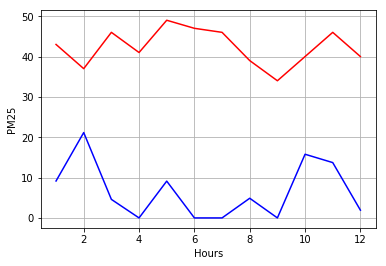

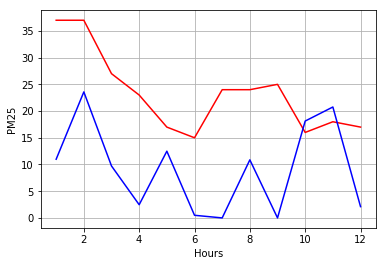

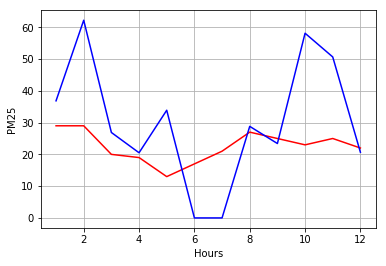

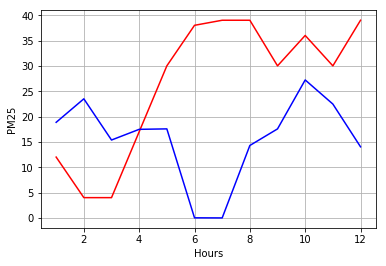

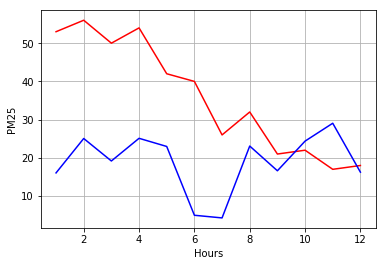

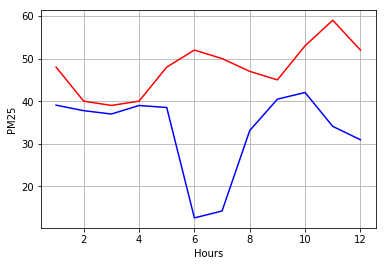

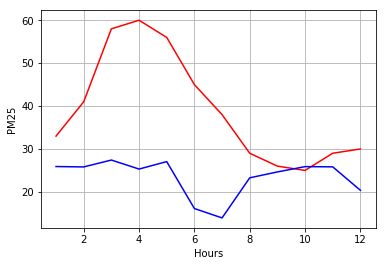

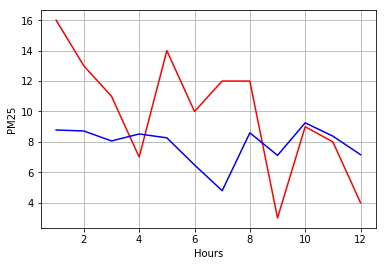

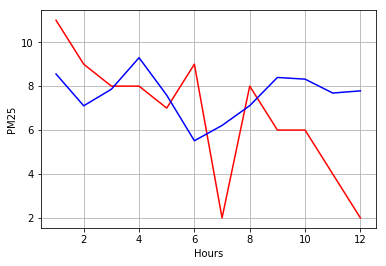

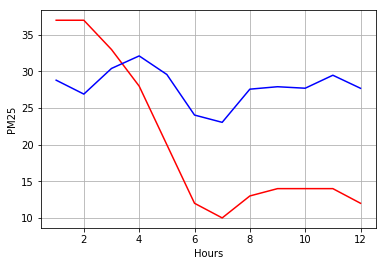

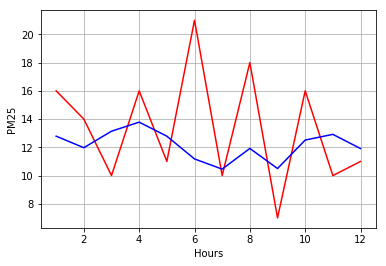

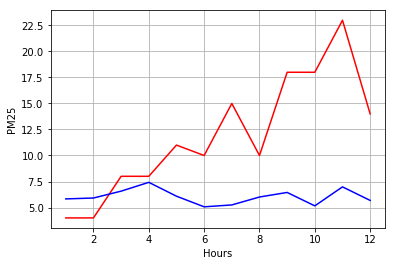

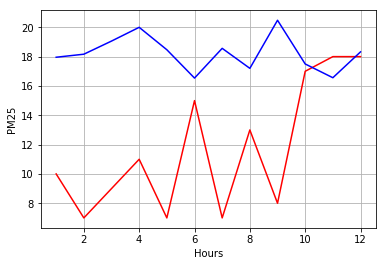

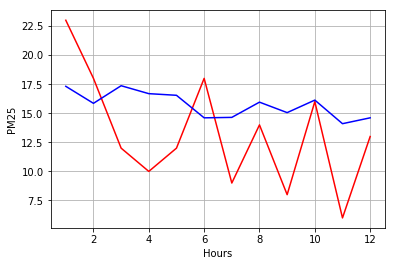

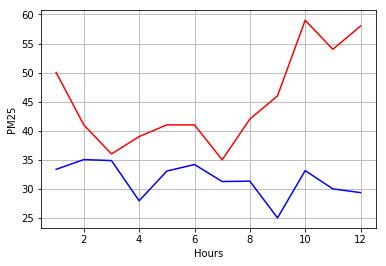

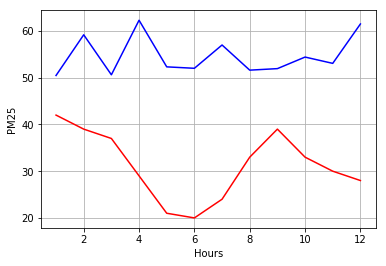

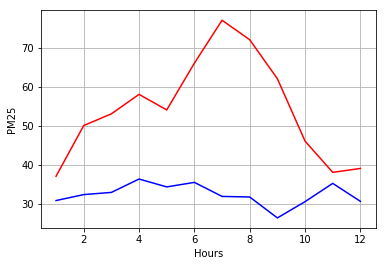

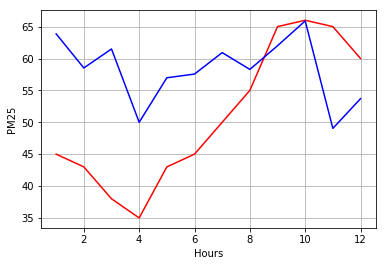

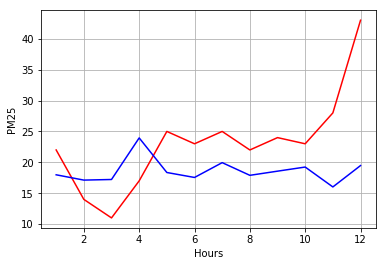

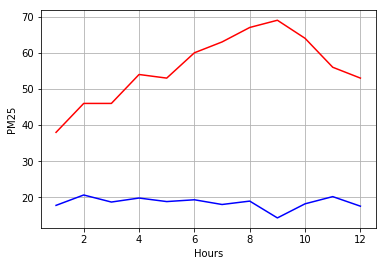

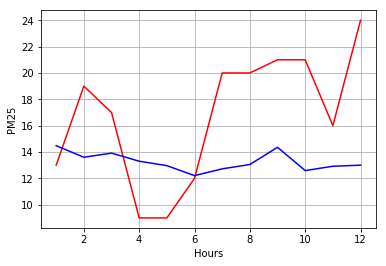

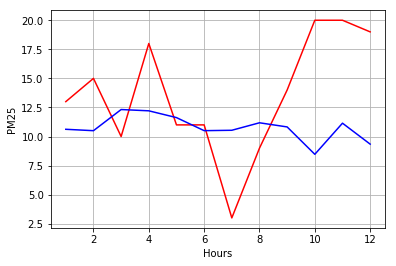

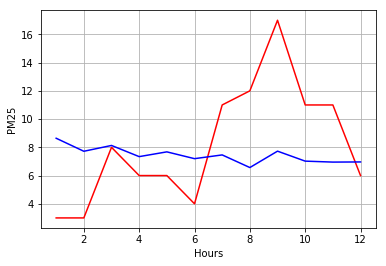

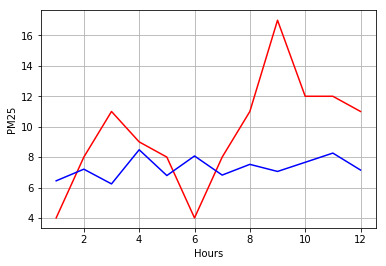

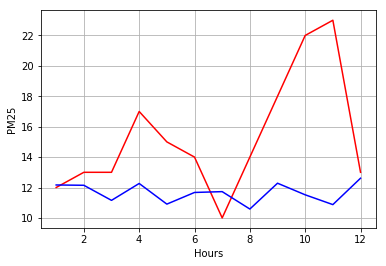

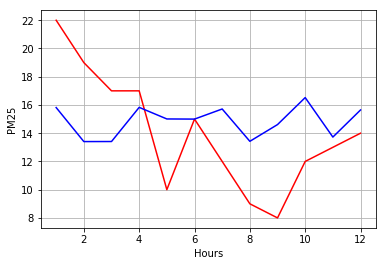

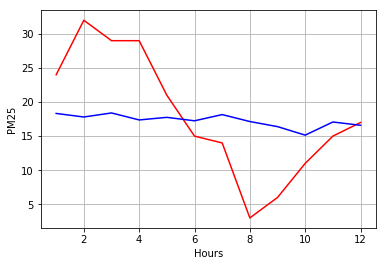

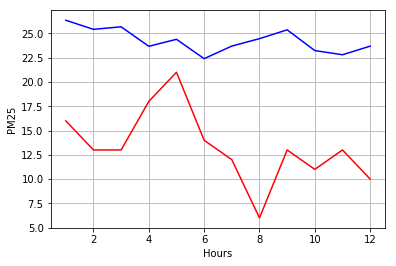

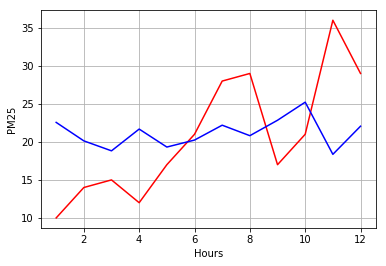

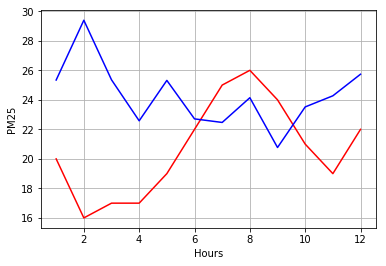

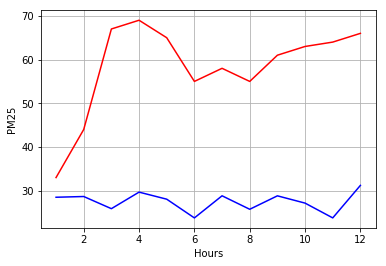

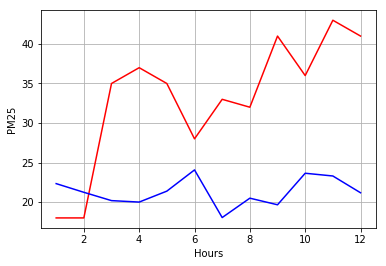

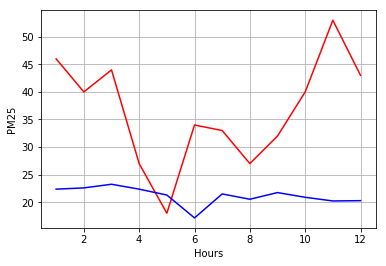

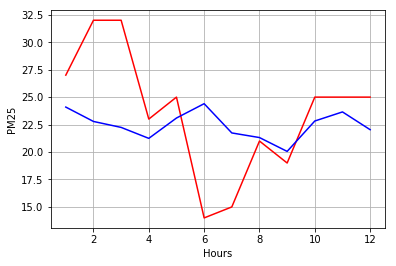

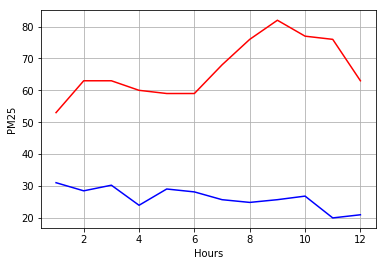

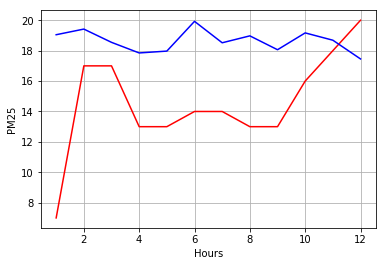

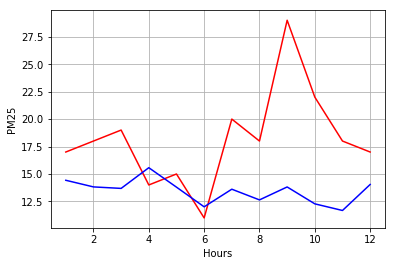

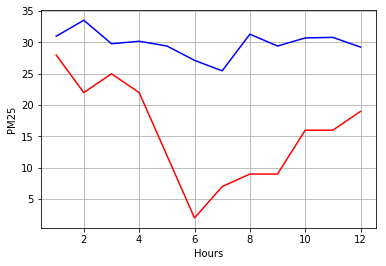

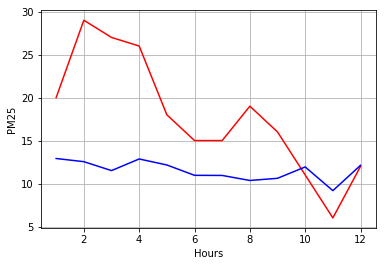

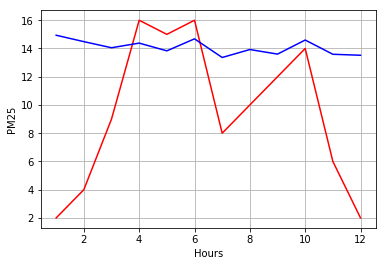

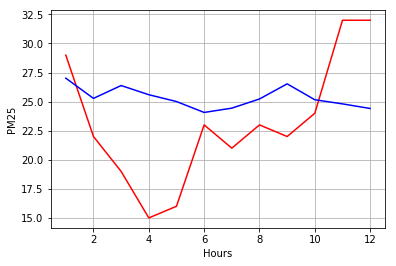

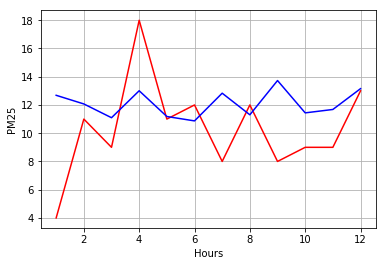

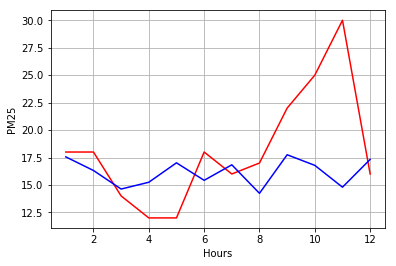

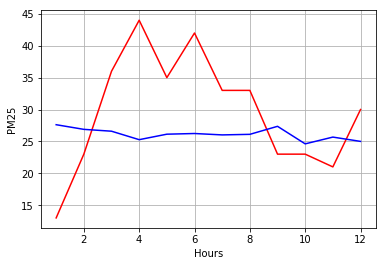

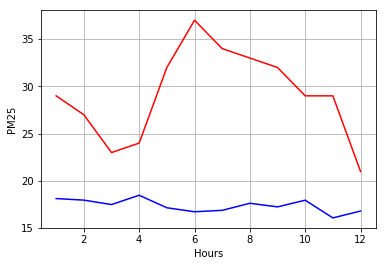

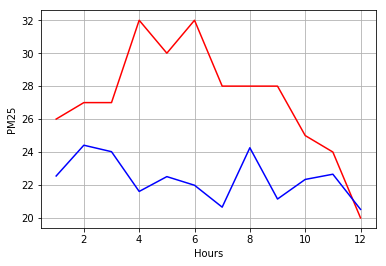

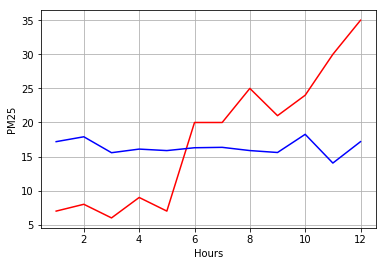

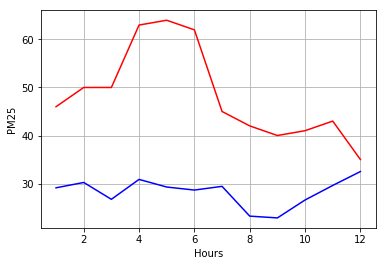

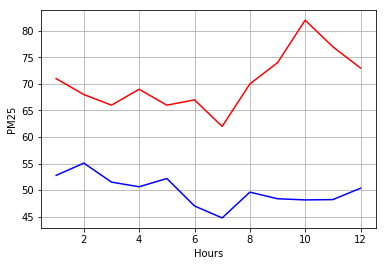

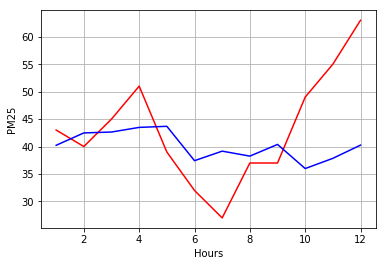

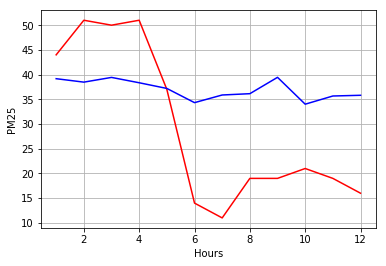

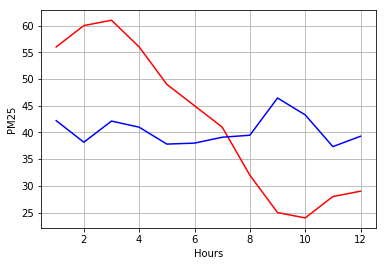

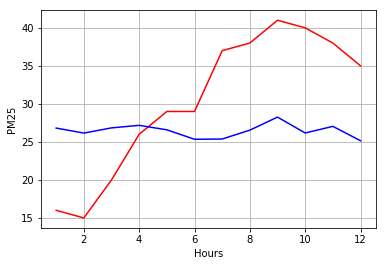

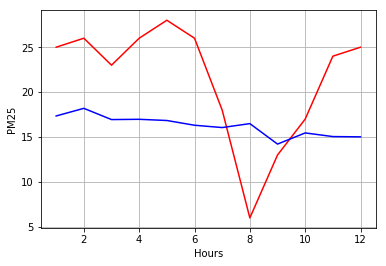

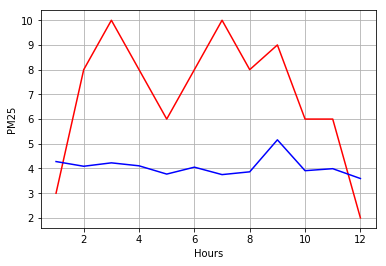

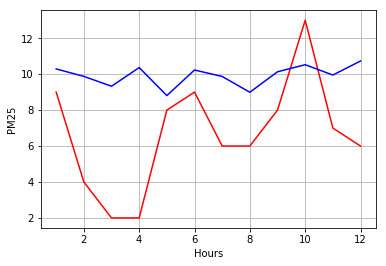

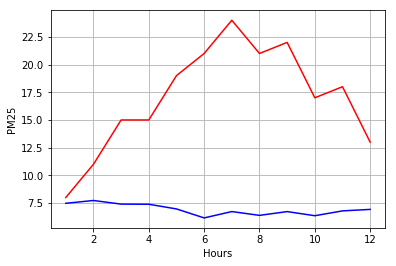

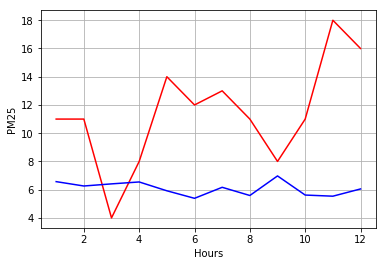

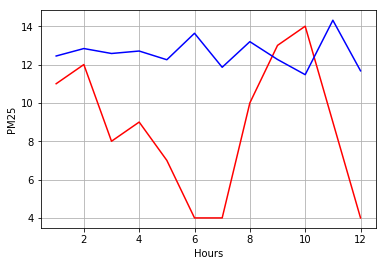

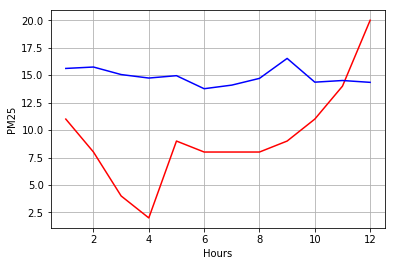

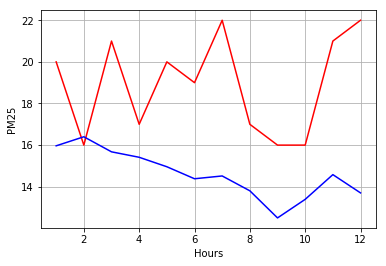

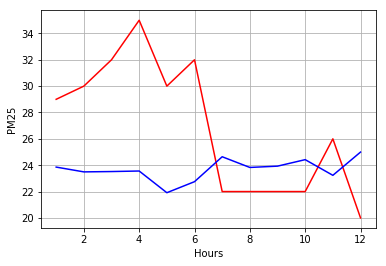

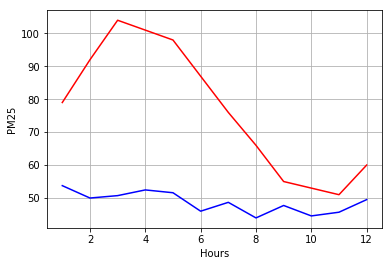

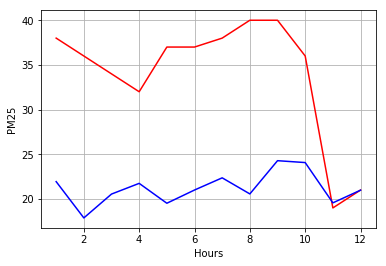

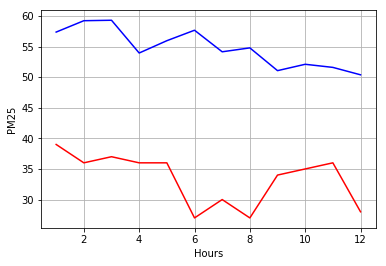

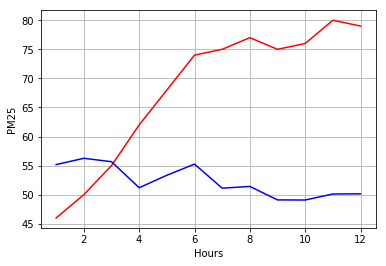

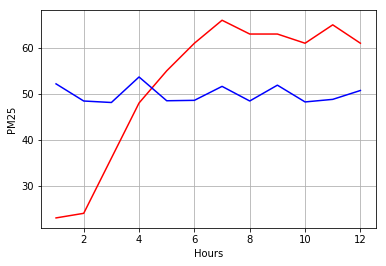

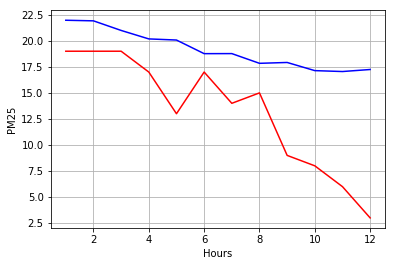

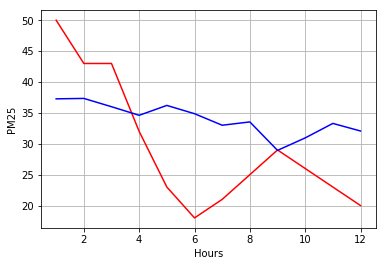

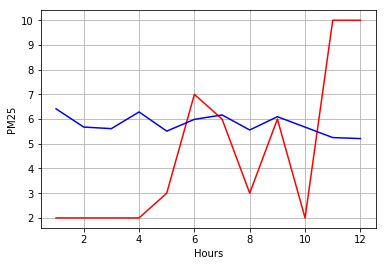

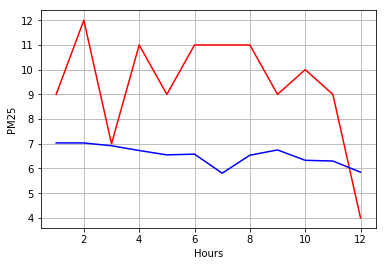

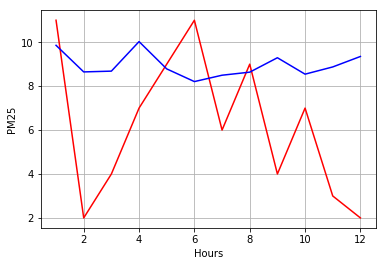

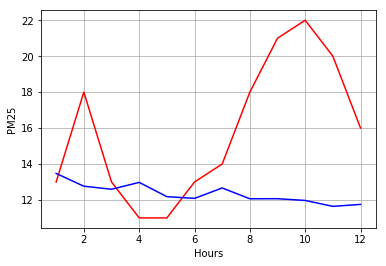

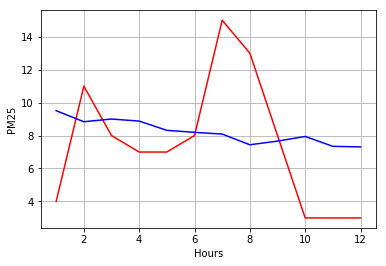

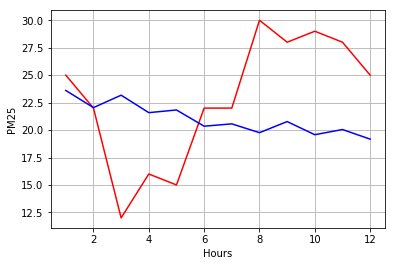

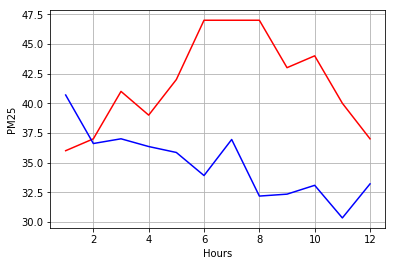

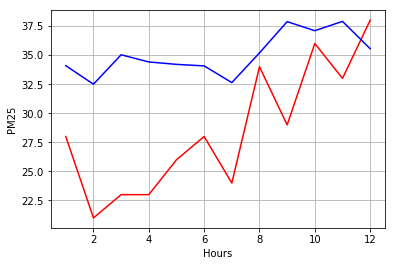

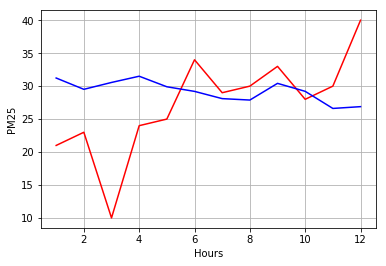

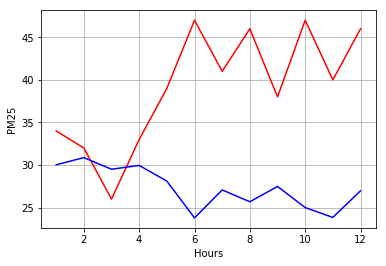

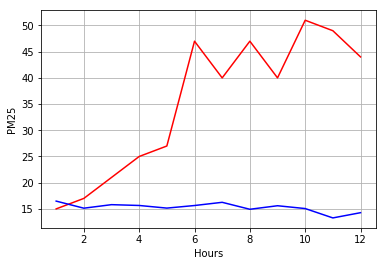

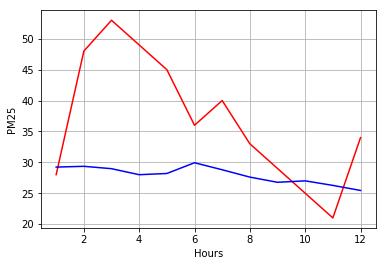

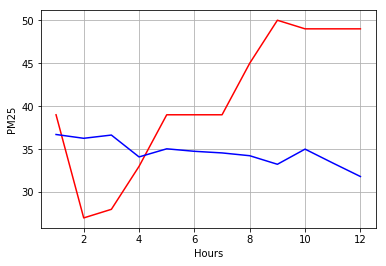

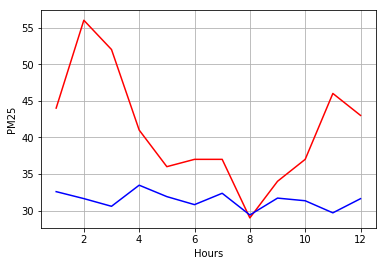

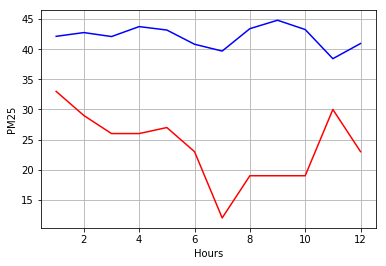

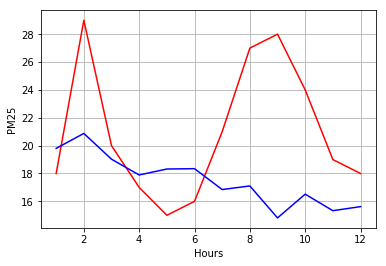

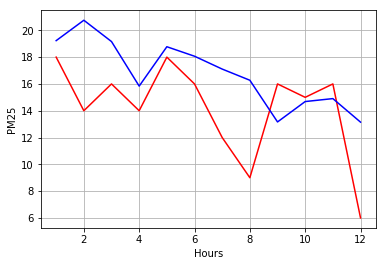

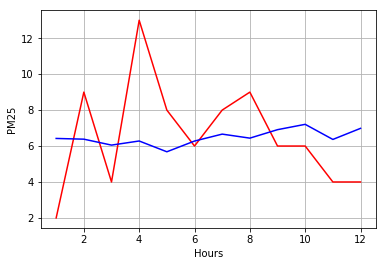

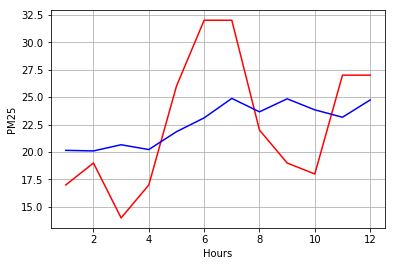

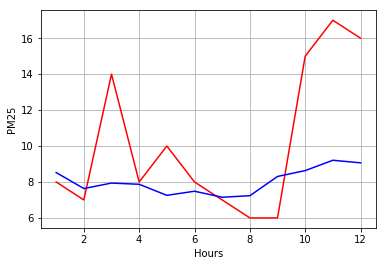

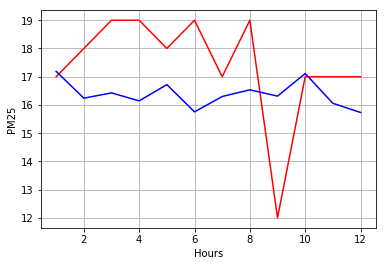

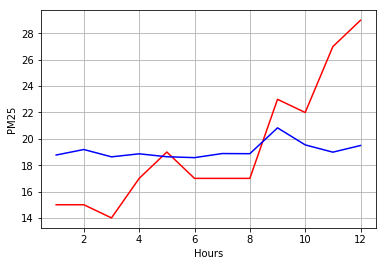

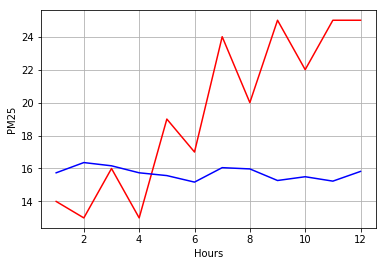

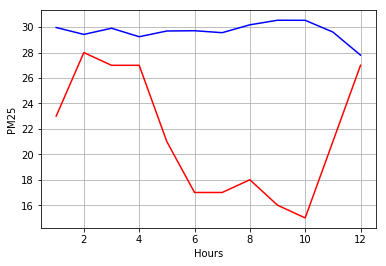

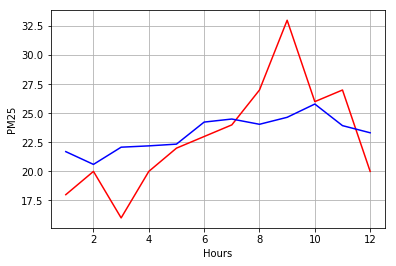

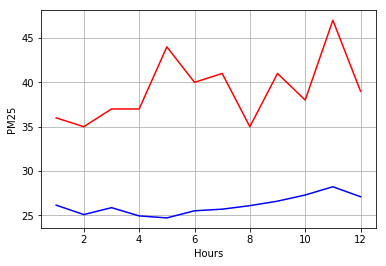

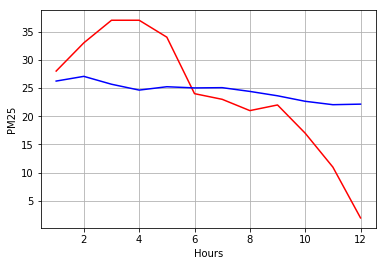

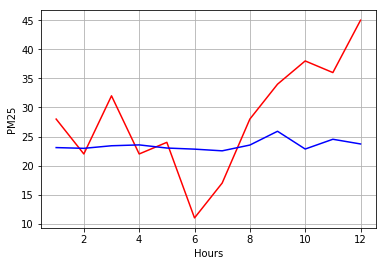

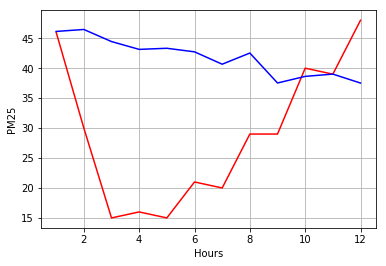

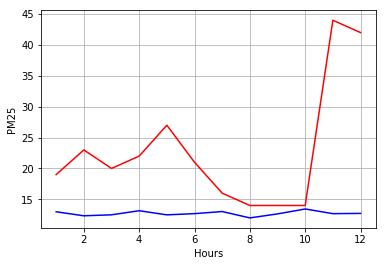

In [42]:
####Try 5:###
#Pure FCN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

class PM25FCN(nn.Module):
    
    def __init__(self):
        super(PM25FCN, self).__init__()
        self.fc1 = nn.Linear(24, 24)
        self.dp1 = nn.Dropout(p = 0.2)
        self.fc2 = nn.Linear(24, 24)
        self.dp1 = nn.Dropout(p = 0.2)
        self.fc3 = nn.Linear(24, 12)
        
    def forward(self, x):
        input_tensor = x.view(-1, 24).to(device)
        #The connection of network
        output = F.relu(self.fc1(input_tensor))
        output = self.dp1(output)
        output = F.relu(self.fc2(output))
        output = F.relu(self.fc3(output))
        return output
    
model_5 = PM25FCN()
model_5.to(device)
print(model_5)


loss_function = nn.MSELoss()
optimizer = optim.Adam(model_5.parameters())
running_loss = 0
epoch = 1000
getter = data_getter(0,data_array.shape[0],0.9)
steps = np.arange(1,13)
hidden_state = None


for e in range(epoch):
    #Get the data
    data, label = getter.get()

    #Zero out the grad in model
    model_5.zero_grad()
    
    #Put them to GPU
    input_data = torch.from_numpy(data).float().to(device)
    label_data = torch.from_numpy(label).float().to(device)

    #Feed the model
    output = model_5(input_data)

    #Train the model
    loss = loss_function(output, label_data)
    loss.backward()

    running_loss += loss.item()
    optimizer.step()
    
    if e and e % 10 == 0:
        fig, ax = plt.subplots()
        ax.plot(steps, label_data[0].cpu().data.numpy(), 'r-', label='real')
        ax.plot(steps, output[0].cpu().data.numpy(), 'b-', label='pred')
        ax.set(xlabel="Hours",ylabel="PM25")
        ax.grid()
        plt.show()
        running_loss = 0